## Results
    Project: Capstone
    Author:  Benedikt Graf
    Version: 11-22-2021

### Import Packages abd Setup Environemnt

In [1]:
### BASIC
import numpy as np # for arrays
import pandas as pd # for panel data
import geopandas as gpd
import random # for random number generation
import matplotlib.pyplot as plt
import os # miscellaneous operating system interfaces
from matplotlib import font_manager
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
# use Goudy Old Style for figures
font_path = '/Users/bgraf/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/Goudy Old Style Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

# set global font properties
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams.update({'font.size': 30})
 
#plt.rcParams["font.family"] = "sans-serif"

### Load Data

In [3]:
def update_sm(county):
    '''
    function to update results from new string-matching function
    uses Swedish county codes for "county"
    '''
    
    ## LOAD DATA
    sm_location = "./data/" + str(county) + "/data_" + str(county) + ".csv"
    geo_location = "./data/" + str(county) + "/results_API_" + str(county) + "_clean.csv"
    
    data_sm = pd.read_csv(sm_location)
    data_geo = pd.read_csv(geo_location)

    ## MERGE DATA
    data = pd.merge(data_geo[["fsid", "ns_birthplace", "latitude", "longitude", "country_API", "county_API"]],
                    data_sm[["fsid", "word_search", "ls_search", "ls_ratio", "jw_search", "jw_ratio"]],
                    right_on = "fsid", left_on ="fsid")
    
    

    data = data[["fsid", "ns_birthplace", 
                 "word_search", "ls_search", "ls_ratio", "jw_search", "jw_ratio",
                 "latitude" , "longitude", "country_API", "county_API"]]
    
    #if(((data_geo["fsid"] == data["fsid"]).sum()) == data.shape[0]) == True:
        #print("OK")
    data.to_csv(geo_location, index=False)

In [4]:
#update_sm(county="ac")

In [5]:
# Load and combine data from all counties

bd = pd.read_csv("./data/bd/results_API_bd_clean.csv")
bd["bcounty"] = 25
ac = pd.read_csv("./data/ac/results_API_ac_clean.csv")
ac["bcounty"] = 24
z = pd.read_csv("./data/z/results_API_z_clean.csv")
z["bcounty"] = 23
y = pd.read_csv("./data/y/results_API_y_clean.csv")
y["bcounty"] = 22
x = pd.read_csv("./data/x/results_API_x_clean.csv")
x["bcounty"] = 21
w = pd.read_csv("./data/w/results_API_w_clean.csv")
w["bcounty"] = 20

full_data = pd.concat([bd, ac, z, y, x, w])

### More Data Cleaning

In [6]:
def remove_inexact(data): 
    '''
    function to remove inexact coordinates
    i.e., the cooridnates Google Maps returns when searching for "Sweden", etc.
    '''
    
    # Sweden
    data.loc[(data['latitude'] == "60.12816100000001") & (data['longitude'] == "18.643501"), 
             ['latitude', 'longitude']] = 'None'
    # Finland
    data.loc[(data['latitude'] == "61.92410999999999") & (data['longitude'] == "25.7481511"), 
             ['latitude', 'longitude']] = 'None'
    # Norway
    data.loc[(data['latitude'] == "60.47202399999999") & (data['longitude'] == "8.468945999999999"), 
             ['latitude', 'longitude']] = 'None'
    # Norrbotten
    data.loc[(data['latitude'] == "66.8309216") & (data['longitude'] == "20.3991966"), 
             ['latitude', 'longitude']] = 'None'
    # Västernorrland
    data.loc[(data['latitude'] == "63.4276473") & (data['longitude'] == "17.7292444"), 
             ['latitude', 'longitude']] = 'None'
    # Västra Götaland
    data.loc[(data['latitude'] == "58.2527926") & (data['longitude'] == "13.0596425"), 
             ['latitude', 'longitude']] = 'None'
    # Västerbotten
    data.loc[(data['latitude'] == "65.3337311") & (data['longitude'] == "16.5161694"), 
             ['latitude', 'longitude']] = 'None'
    # Jämtland
    data.loc[(data['latitude'] == "63.1711922") & (data['longitude'] == "14.95918"), 
             ['latitude', 'longitude']] = 'None'
    # Dalarna
    data.loc[(data['latitude'] == "61.0917012") & (data['longitude'] == "14.6663653"), 
             ['latitude', 'longitude']] = 'None'
    
    return(data)

### Results

In [7]:
def geopandas_join(county_code, county_id, full):
    '''
    function to load, clean, geojoin geocoding results
    if "full" is False, results for one county are displayed
    "county_code" and "county_id" must match
    '''
    
    ### LOAD DATA
    
    # set file location
    location = "./data/" + str(county_code) + "/results_API_" + str(county_code) + "_clean.csv"
    # load data
    data = pd.read_csv(location)
    
    
    if full == True:
        data = full_data
    ### CLEAN DATA
    
      # number of observations
    obs = data.shape[0]
    
    # remove inexact observations
    data = remove_inexact(data=data)
    
    # remove observations w/out coordinates and those not in Sweden, Norwway, or Finland
    data = data.loc[(data['latitude'] != "None") | 
                    (data['longitude'] != "None")]
    data = data.loc[(data['country_API'] == "Sweden") | 
                    (data['country_API'] == "Norway") | 
                    (data['country_API'] == "Finland")]

    ### JOIN DATA
    
    # turn dataframe into coordinates
    points = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude),crs='epsg:4326')
    # load shapefile of Swedish parishes (in year 1820)
    hist_shp = gpd.read_file('./data/geo/SE_parishes.shp')
    # merge dataframes
    dfsjoin = gpd.sjoin(hist_shp, points)
    
    #display(dfsjoin.head(5))
    
    ### RESULTS
    
    # % located
    if full==True:
        percent_loc = dfsjoin.shape[0]/obs
        print("% Located:", round(percent_loc,3))
    
    if full==False:
        dfsjoin = dfsjoin[(dfsjoin["county"] == county_id) |
                          (dfsjoin["county"] == county_id - 1) |
                          (dfsjoin["county"] == county_id + 1)]
        percent_loc = dfsjoin.shape[0]/obs
        print("% Located:", round(percent_loc,3))
    
    return(hist_shp, points, dfsjoin)

In [8]:
def match_matrix(county_code, county_id, geodata, full):
    '''
    function to build matching matrix
    if "full" is False, results for one county are displayed
    "county_code" and "county_id" must match
    '''
    
    ## PERCENT LOCATED BY METHOD
    
    ### LOAD DATA
    
    # set file location
    location = "./data/" + str(county_code) + "/results_API_" + str(county_code) + "_clean.csv"
    # load data
    data = pd.read_csv(location)
    
    if full == True:
        data = full_data
    ### CLEAN DATA
    
    obs = data.shape[0]
    
    ws_idd = data[data['word_search'] != "Not identified"].shape[0]
    ws_loc = round(ws_idd/obs, 3)
    
    ls_idd = data[data['ls_search'] != "Not identified"].shape[0]
    ls_loc = round(ls_idd/obs, 3)
    
    jw_idd = data[data['jw_search'] != "Not identified"].shape[0]
    jw_loc = round(jw_idd/obs, 3)
    
    if full==True:
        geodata = geodata[(geodata["county"] == geodata["bcounty"]) |
                          (geodata["county"] == (geodata["bcounty"] -1)) |
                          (geodata["county"] == (geodata["bcounty"] +1 ))]
    if full==False:
        geodata = geodata[(geodata["county"] == county_id) |
                          (geodata["county"] == county_id - 1) |
                          (geodata["county"] == county_id + 1)]
        
    geo_idd = geodata.shape[0]
    geo_loc = round(geo_idd/obs,3)
    
    ## PERCENT MATCHING
    
    #for col in ['word_search', 'ls_search', 'jw_search']:
    #    data = data[~data[col].isin(['Not identified'])]
        
    data_an = data[~data["word_search"].isin(['Not identified'])]
    data_an = data_an[~data_an["ls_search"].isin(['Not identified'])]
    ws_ls = round((data_an['word_search'] == data_an['ls_search']).sum()/data_an.shape[0], 3)
    
    data_an = data[~data["word_search"].isin(['Not identified'])]
    data_an = data_an[~data_an["jw_search"].isin(['Not identified'])]
    ws_jw = round((data_an['word_search'] == data_an['ls_search']).sum()/data_an.shape[0], 3)
    
    data_an = data[~data["jw_search"].isin(['Not identified'])]
    data_an = data_an[~data_an["ls_search"].isin(['Not identified'])]
    ls_jw = round((data_an['ls_search'] == data_an['jw_search']).sum()/data_an.shape[0], 3)
    #test  = round(((data['ls_search'] == data['ls_search']).sum())/data.shape[0], 3)

    #for col in ['word_search', 'ls_search', 'jw_search']:
    #    geodata = geodata[~geodata[col].isin(['Not identified'])]
    
    geodata_an = geodata[~geodata["word_search"].isin(['Not identified'])]    
    geo_ws = round((geodata_an["socken"] == geodata_an["word_search"]).sum()/geodata_an.shape[0], 3)
    
    geodata_an = geodata[~geodata["ls_search"].isin(['Not identified'])]
    geo_ls = round((geodata_an["socken"] == geodata_an["ls_search"]).sum()/geodata_an.shape[0], 3)
    
    geodata_an = geodata[~geodata["jw_search"].isin(['Not identified'])]
    geo_jw = round(((geodata_an["socken"] == geodata_an["jw_search"]).sum())/geodata_an.shape[0], 3)
    #test2 = round((geodata["socken"] == geodata["socken"]).sum()/geodata.shape[0], 3)
    
    ## ADD TO MATRIX
        
    matrix = {'String-Search': [], 'Levenshtein': [], 'Jaro-Winkler': [], 'Geocoding': []}
    df_matrix = pd.DataFrame(data=matrix)
    df_matrix.loc['String-Search'] = [ws_loc, ws_ls, ws_jw, geo_ws]
    df_matrix.loc['Levenshtein']   = [ws_ls, ls_loc, ls_jw, geo_ls]
    df_matrix.loc['Jaro-Winkler']  = [ws_jw, ls_jw, jw_loc, geo_jw]
    df_matrix.loc['Geocoding']     = [geo_ws, geo_ls, geo_jw, geo_loc]
    
    return(obs, df_matrix)

### Plot Results

In [9]:
def point_count_map(hist_shp, points, dfsjoin, county_id, confirm, mlarge, full):
    '''
    function to find obs. per parish and map results
    if "full" is False, results for one county are displayed
    if "confirm" is False all geocoding results are plotted
    if "confirm" is True only results corroborated by string-matching are plotted
    if "mlarge" is True, a larger map will be plotted
    '''
    
    # calculate number of observations by parish
    point_count = dfsjoin.socken.value_counts().reset_index().\
    rename(columns={'index':'socken','socken':'point_count'})
    
    # merge point count with shapefile
    hist_shp = hist_shp.merge(point_count, on='socken', how='left')
    
    # fill missing values
    hist_shp['point_count'].fillna(0, inplace=True)
    #hist_shp['point_count'] = hist_shp['point_count']/hist_shp.shape[0]
    
    # implied density per km2 - could also plot this
    hist_shp['point_count_area'] =  hist_shp['point_count']/hist_shp['area']
    
    # restrict to county under investigation
    if full == False:
        hist_shp = hist_shp[hist_shp['county'] == county_id]
    
    # load county layer
    county_shp = gpd.read_file('./data/geo/SE_counties.shp')
    
    # load other countries' shapefiles
    fin_shp = gpd.read_file('./data/geo/gadm36_FIN_shp/gadm36_FIN_0.shp')
    nor_shp = gpd.read_file('./data/geo/gadm36_NOR_shp/gadm36_NOR_0.shp')
    dnk_shp = gpd.read_file('./data/geo/gadm36_DNK_shp/gadm36_DNK_0.shp')
    est_shp = gpd.read_file('./data/geo/gadm36_EST_shp/gadm36_EST_0.shp')
    lva_shp = gpd.read_file('./data/geo/gadm36_LVA_shp/gadm36_LVA_0.shp')
    ltu_shp = gpd.read_file('./data/geo/gadm36_LTU_shp/gadm36_LTU_0.shp')
    rus_shp = gpd.read_file('./data/geo/gadm36_RUS_shp/gadm36_RUS_0.shp')
    ala_shp = gpd.read_file('./data/geo/gadm36_ALA_shp/gadm36_ALA_0.shp')
    
    ### MAP
    
    if mlarge == True:
        fsize = 40
        msize = 7
        figsize = (30,30)
        
    if mlarge == False:
        fsize = 30
        msize = 4
        figsize = (15,15)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # countries
    
    ec_set = "grey"
    
    fin_shp.simplify(0.0300).plot(ax=ax, fc="white", ec=ec_set, alpha=1)
    nor_shp.simplify(0.0250).plot(ax=ax, fc="white", ec=ec_set, alpha=1)
    dnk_shp.simplify(0.00250).plot(ax=ax, fc="white", ec=ec_set, alpha=1)
    est_shp.plot(ax=ax, fc="white", ec=ec_set, alpha=1)
    lva_shp.plot(ax=ax, fc="white", ec=ec_set, alpha=1)
    ltu_shp.plot(ax=ax, fc="white", ec=ec_set, alpha=1)
    rus_shp.simplify(0.000250).plot(ax=ax, fc="white", ec=ec_set, alpha=1)
    ala_shp.simplify(0.000250).plot(ax=ax, fc="white", ec=ec_set, alpha=1)

    # counties
    
    county_shp.plot(ax=ax, fc="white", ec="black", alpha=1)
    
    county_shp = county_shp[(county_shp['letter'] == "BD") | 
                            (county_shp['letter'] == "AC") | 
                            (county_shp['letter'] == "Z") |
                            (county_shp['letter'] == "Y") |
                            (county_shp['letter'] == "X") |
                            (county_shp['letter'] == "W")]
    
    county_shp.plot(ax=ax, fc="lightgrey", ec="black", alpha=1)
    
    # parishes
    # hist_shp.plot(ax=ax, color='lightgrey', ec="grey")
    # hist_shp.plot(ax=ax ,column='point_count',legend=True, cmap=plt.get_cmap("RdYlBu_r"), ec="black")
    
    points2 = gpd.GeoDataFrame(dfsjoin, geometry=gpd.points_from_xy(dfsjoin.longitude, dfsjoin.latitude),
                               crs='epsg:4326')
    points2["backed"] = np.where((points2["ls_search"] == points2["socken"]), 1, 0)
    
    points_not_backed = points2[points2.backed == 0]
    points_backed = points2[points2.backed == 1]
    #print(points2.shape[0])
    #print(points_backed.shape[0])
    #print(points_not_backed.shape[0])
    
    alpha=0.75
    
    # points
    if confirm == True:
        points_backed.plot(ax=ax, markersize=msize, marker="o", color='#A41034', #006633
                           label="Confirmed by String-Matching", alpha=alpha)
        ax.set_title("(b) Confirmed by String-Matching", loc='center', pad=15, fontsize=fsize)
        
    if confirm == False:
        points.plot(ax=ax,markersize=msize, marker = "o", color='#A41034',  #0c2340
                               label="Geocoding Results", alpha=alpha)
        ax.set_title("(a) Geocoding Results", loc='center', pad=15, fontsize=fsize)
        
       
    # Axis format
    ax.set_xlabel('Latitude', fontsize=fsize)
    ax.set_ylabel('Longitude', fontsize=fsize)
    ax.xaxis.labelpad = 23
    ax.yaxis.labelpad = 23
    plt.xlim([7.5, 25])
    plt.ylim([55, 69.5])
    ax.set_facecolor('#A3BFF4')
    
    # LEGEND
    
    # Shrink current axis by 20%
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])

    # Put a legend to the right of the current axis
    #ax.legend(loc='center left', )
    #ax.legend(markerscale=4, framealpha=0.95, fontsize = 35, 
    #          loc= 'upper center', bbox_to_anchor=(0.5, 1.05), frameon=False)

    # returning point count for reference
    return(point_count)

### County-level Results (Table 4)

In [10]:
res = pd.DataFrame(columns=["N", "String-Search", "Levenshtein", "Jaro-Winkler", "Geocoding"])
df_res = pd.DataFrame(data=res)

df_res

cid = 25
for cc in ["bd", "ac", "z", "y", "x", "w"]:
    
    hist_shp, points, dfsjoin = geopandas_join(county_code=cc, county_id=cid, full=False)
    obs, cmatrix = match_matrix(county_code=cc, county_id=cid, geodata=dfsjoin, full=False)
    
    df_res.loc[cc] = [obs, cmatrix.iloc[0,0], cmatrix.iloc[1,1], cmatrix.iloc[2,2], cmatrix.iloc[3,3]]
    
    cid-=1
    
df_res    

% Located: 0.856
% Located: 0.833
% Located: 0.725
% Located: 0.735
% Located: 0.848
% Located: 0.812


,N,String-Search,Levenshtein,Jaro-Winkler,Geocoding
bd,4361.0,0.657,0.711,0.736,0.856
ac,4758.0,0.687,0.714,0.738,0.833
z,3498.0,0.627,0.672,0.731,0.725
y,5414.0,0.709,0.749,0.793,0.735
x,3686.0,0.715,0.766,0.803,0.848
w,6409.0,0.671,0.763,0.797,0.812


In [11]:
hist_shp, points, dfsjoin = geopandas_join(county_code="ac", county_id=24, full=True)

% Located: 0.829


### Matching Matrix (Table 5)

In [12]:
obs, matrix = match_matrix(county_code="ac", county_id=24, geodata=dfsjoin, full=True)
display(matrix)
print(obs)

,String-Search,Levenshtein,Jaro-Winkler,Geocoding
String-Search,0.679,0.976,0.974,0.873
Levenshtein,0.976,0.733,1.000,0.878
Jaro-Winkler,0.974,1.000,0.769,0.865
Geocoding,0.873,0.878,0.865,0.802


28126


### Map of Geocoding Results (Figure 3)

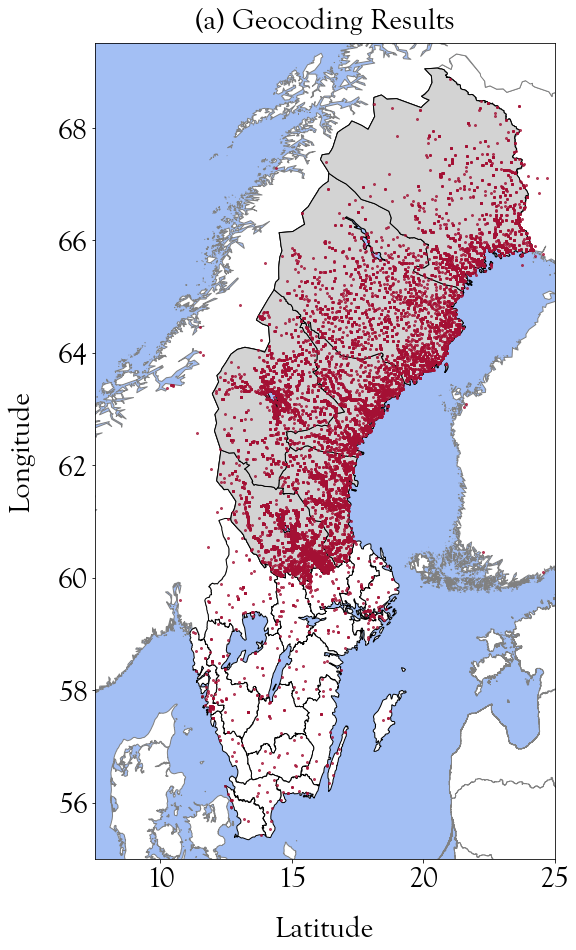

In [13]:
point_count = point_count_map(hist_shp=hist_shp, points=points, dfsjoin=dfsjoin, 
                              county_id=22, confirm=False, mlarge=False, full=True)

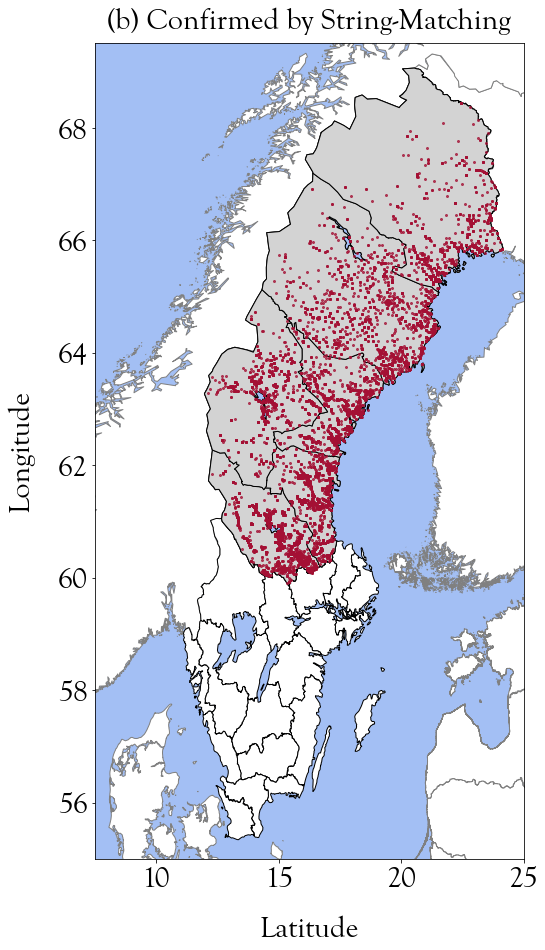

In [14]:
point_count = point_count_map(hist_shp=hist_shp, points=points, dfsjoin=dfsjoin, 
                              county_id=22, confirm=True, mlarge=False, full=True)